# OpSim -- simulation

## About

This notebook is for testing of the OpSim functionality.
An attempt was made to simplify code, so in most cases we
rely on the precalculated Sun trajectory and the solar
panel power output profile, loaded from files.

In [69]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility

import numpy as np
import matplotlib.pyplot as plt
import simpy


In [80]:
# Load lusee and OpSim

import  lusee
from    nav        import * # includes luseepy
from    bms.parts  import * # Battery, Controller
from    bms.panels import *
# ----------------------------------------------------
print(f'''simpy version: {simpy.__version__}''')
print(f'''lusee version: {lusee.__version__}''')


simpy version: 4.0.2
lusee version: 1.2-dev


In the following, we have an option to read:
* _prefab data for the Sun trajectory_
* precalculated _panel power output profile_.


In [71]:
# Read the prefab data on sun trajectory
import os
from nav import Sun
print('Current directory:', os.getcwd())

mySun = Sun()

cachefile = '../data/2025-02-04_03-07.npy'
mySun.read(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')

sun = mySun.xyz # altaz2xyz(mySun.alt, mySun.az)
hrs = mySun.hrsFromSunrise()


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


In [72]:
import os
print('Current directory:', os.getcwd())
power_cachefile = '../data/2025-02-04_03-07_power.npy'
# with open(power_cachefile, 'rb') as f: pwr = np.load(f) #print(f'''Number of points read from the file {power_cachefile}: {pwr.size}''')

Panel.verbose = True
Panel.read_profile(power_cachefile)


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Loaded data from file "../data/2025-02-04_03-07_power.npy", number of points: 2993


---

Optionally, print out number to check if they make sense...

In [ ]:
# To check the numerical values -- if sufficient, simply convert to a Python list: #a = list(pwr) print(*a, sep = ", ")
# Or, print power values with the MJD timestamps:
print(f'''Will attempt to access {mySun.N} points {Panel.profile}''')
for i in range(0, mySun.N):
    print("%5.3f: %5.3f" % (mySun.mjd[i], Panel.profile[i]))


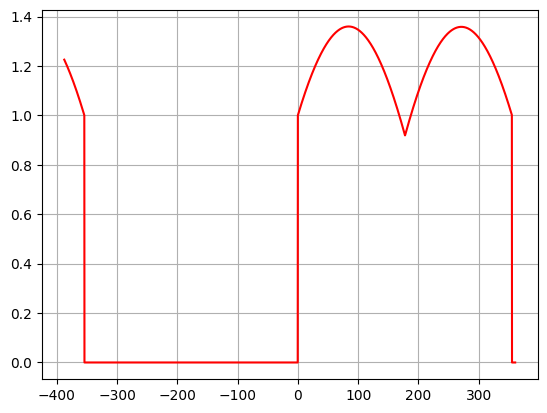

In [73]:

plt.plot(hrs, Panel.profile, color="red",    label="total")
# plt.xlim(-100,400)
plt.grid(True)


In [81]:
env = simpy.Environment()

battery = Battery() # a dummy battery here, just to create the controller

ctr     = Controller(battery, env, hrs)
ctr.add_all_panels(mySun)
ctr.set_condition(mySun.condition)

env.process(ctr.run())

env.run(until=15)

ctrHrdwr = ControllerHardware('f', True)



Clock: -387.5000000000582, power: 1.2253604302020147
Clock: -387.2500000001164, power: 1.2240406818404967
Clock: -387.0, power: 1.2227149841319656
Clock: -386.7500000000582, power: 1.2213833436658157
Clock: -386.5000000001164, power: 1.2200457670603484
Clock: -386.25, power: 1.2187022609621851
Clock: -386.0000000000582, power: 1.2173528320473288
Clock: -385.7500000001164, power: 1.2159974870205839
Clock: -385.5, power: 1.2146362326155165
Clock: -385.2500000000582, power: 1.2132690755944218
Clock: -385.0000000001164, power: 1.2118960227477225
Clock: -384.75, power: 1.2105170808956203
Clock: -384.5000000000582, power: 1.2091322568863754
Clock: -384.2500000001164, power: 1.20774155759683
Clock: -384.0, power: 1.2063449899323706
